# Introduction: 
Spam e-mail has become a very serious problem. Sending inappropriate messages to a large number of recipients has resulted in anger by users but large profits for spammers. In this part, I will walk through of building a simple text classifier which will identify Spam and Ham Emails which tags 5,172 text messages based on whether they are “spam” or “ham” (not spam).

#### This notebook is structured as follows:

1) Exploratory Data Analysis : In this section, we will explore the features and visualise the data and their relation.

2) Data Preprocessing: Removing Stop words, Lemmetize the text, Remove all the special characters, puctuations etc. 

3) Implementing Machine Learning models : Implement a range of machine learning models and validate how they are performing.

4) Perform Hyperparameter Optimisation : SVM and Random Forest

5) Evaluate Best Model and apply various performence measures.

In [15]:
## Few packages to install before we start running the ipynb notebook. 

#pip install WordCloud
#conda install -c anaconda py-xgboost
#pip install imblearn
#pip install seaborn

In [1]:
import os
import pandas as pd
import codecs
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
from sklearn.model_selection import cross_val_score,GridSearchCV
import numpy as np
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

In [29]:
# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# modelling librarires
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

## Reading Files:

In the Below lines of code,I will read files name Ham and spam ,Here I am using os.listdir 
since i need to read the contents of a file from the list of files from a directory with os.listdir,
Reading each file from the directory and appending into a list for Ham and spam,My working scriptlet is as follows:

In [4]:
from collections import Counter
direc = 'D:/Sem2/Machine Learning/enron1.tar/enron1/spam/'
san = 'D:/Sem2/Machine Learning/enron1.tar/enron1/ham/'
files = os.listdir(direc)
files1 = os.listdir(san)
spam_list = []
for email in files:
    f=open(direc+email,"r",encoding="utf8", errors='ignore')
    blob=f.read()
    spam_list.append(blob)
#print(len(words))
ham_list = []
for email1 in files1:
    f=open(san+email1,"r",encoding="utf8", errors='ignore')
    blob=f.read()
    ham_list.append(blob)
    

## Data Frame

In the below lines of code, with the help of Pandas Library combining tags such as 'Emails'
and 'Category' into a single Data Frame.

In [5]:
spam_df = pd.DataFrame(spam_list)
spam_df["Category"] = 'spam'
ham_df = pd.DataFrame(ham_list)
ham_df["Category"] = 'ham'
df = pd.concat([spam_df, ham_df], ignore_index= True)
df.rename(columns = {0:'Emails'}, inplace = True)
df

,Emails,Category
0,Subject: dobmeos with hgh my energy level has ...,spam
1,Subject: your prescription is ready . . oxwq s...,spam
2,Subject: get that new car 8434\npeople nowthe ...,spam
3,"Subject: await your response\ndear partner ,\n...",spam
4,"Subject: coca cola , mbna america , nascar par...",spam
...,...,...
5167,Subject: re : tenaska iv\ni ' ll call you on t...,ham
5168,"Subject: generic contract\nhi daren ,\nsorry f...",ham
5169,Subject: re : contracts and credit\nthanks - -...,ham
5170,"Subject: re : tenaska iv\nok , since we don ' ...",ham


## Data Overview

Get the insights of the data with df.info(), which tags 5172 Emails with Ham and Spam.

In [6]:
#Dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Data columns (total 2 columns):
Emails      5172 non-null object
Category    5172 non-null object
dtypes: object(2)
memory usage: 80.9+ KB


In [7]:
#Classify the Columns Emails and category
text = df['Emails']
target = df['Category']

## PreProcessing

I feel, Data PreProcessing in one of the important part for text classification, In this part my
goal is Firstly, to convert all the 'Numbers' into 'Text'. Secondly, all the weblinks in to the
'Simple Text format'.

#### Case Normalization :

Coverting all the upper case text into Lower case. Why? Does "GOOD" semantically read as "good?" we
can assume based on our prior knowledge may be "GOOD" sounds more important just to catch the attention.
I think in order to remove this kind of confusion it is good idea to perform Casing.

* Remove special characters from emails and httRemoving web links from the text data as they are not pretty much useful
* Removing punctuations from the text
* Removing apostrophes from the text to correct words like we've to we have
* Replace "-" to space
* Replace Symbols such as "$" with 'moneysymb'
* Replace Numbers to 'numbr'
* Replace phone number digits with text 'phonenumbr'

#### Remove Stop Words -- Why it is important to remove stop words? Few Reasons below:

* Firstly, stop words such as 'an','a','the','at' etcsomtimes does not make any sense to
  the corpus.
* Secondaly, stop words have high frequency, removing the stop words we will end up with reduced       dataset size as well better performence
* Moreover, Accoring to text classification we want the Rare Words more so that TF-IDF can correctly   provide more value to Rare words instead of repetative words.

#### Note: Stop words can be anything which repeats more.

#### Lemmitization 

Lemmtization is the Process of linking words together to form sentence which can be further analyzed as a single item. 


In [8]:
#Clean the dataset
#text preprocessing
import re
word_processed = text.str.replace(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b',
                                 'emailaddr')
word_processed = word_processed.str.replace(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)',
                                  'httpaddr')
word_processed = word_processed.str.replace('£|\$', 'moneysymb')
word_processed = word_processed.str.replace(r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b',
'phonenumbr')
word_processed = word_processed.str.replace(r'\d+(\.\d+)?', 'numbr')
word_processed = word_processed.str.replace(r'[^\w\d\s]', ' ')
word_processed = word_processed.str.replace(r'\s+', ' ')
word_processed = word_processed.str.replace(r'^\s+|\s+?$', '')
word_processed = word_processed.str.replace('[0-9]+$', '')
word_processed = word_processed.str.replace('|[,:;_-]+','')
#convert to lower string
word_processed = word_processed.str.lower()
word_processed
df["clean"] = word_processed
df.head()

,Emails,Category,clean
0,Subject: dobmeos with hgh my energy level has ...,spam,subject dobmeos with hgh my energy level has g...
1,Subject: your prescription is ready . . oxwq s...,spam,subject your prescription is ready oxwq s f e ...
2,Subject: get that new car 8434\npeople nowthe ...,spam,subject get that new car numbr people nowthe w...
3,"Subject: await your response\ndear partner ,\n...",spam,subject await your response dear partner we ar...
4,"Subject: coca cola , mbna america , nascar par...",spam,subject coca cola mbna america nascar partner ...


In [9]:
#Remove the stop words
stop_words = nltk.corpus.stopwords.words('english')
word_processed= word_processed.apply(lambda x: ' '.join(term for term in x.split() if term not in set(stop_words)))
df["stop words removal"]= word_processed
df.head()

,Emails,Category,clean,stop words removal
0,Subject: dobmeos with hgh my energy level has ...,spam,subject dobmeos with hgh my energy level has g...,subject dobmeos hgh energy level gone stukm in...
1,Subject: your prescription is ready . . oxwq s...,spam,subject your prescription is ready oxwq s f e ...,subject prescription ready oxwq f e low cost p...
2,Subject: get that new car 8434\npeople nowthe ...,spam,subject get that new car numbr people nowthe w...,subject get new car numbr people nowthe weathe...
3,"Subject: await your response\ndear partner ,\n...",spam,subject await your response dear partner we ar...,subject await response dear partner team gover...
4,"Subject: coca cola , mbna america , nascar par...",spam,subject coca cola mbna america nascar partner ...,subject coca cola mbna america nascar partner ...


In [10]:
#Lemmetize the stop words now
wn = nltk.WordNetLemmatizer()
word_processed = word_processed.apply(lambda x: ' '.join(wn.lemmatize(term) for term in x.split()))
df["lemmetize"] = word_processed
df.head(20)

,Emails,Category,clean,stop words removal,lemmetize
0,Subject: dobmeos with hgh my energy level has ...,spam,subject dobmeos with hgh my energy level has g...,subject dobmeos hgh energy level gone stukm in...,subject dobmeos hgh energy level gone stukm in...
1,Subject: your prescription is ready . . oxwq s...,spam,subject your prescription is ready oxwq s f e ...,subject prescription ready oxwq f e low cost p...,subject prescription ready oxwq f e low cost p...
2,Subject: get that new car 8434\npeople nowthe ...,spam,subject get that new car numbr people nowthe w...,subject get new car numbr people nowthe weathe...,subject get new car numbr people nowthe weathe...
3,"Subject: await your response\ndear partner ,\n...",spam,subject await your response dear partner we ar...,subject await response dear partner team gover...,subject await response dear partner team gover...
4,"Subject: coca cola , mbna america , nascar par...",spam,subject coca cola mbna america nascar partner ...,subject coca cola mbna america nascar partner ...,subject coca cola mbna america nascar partner ...
5,Subject: emerging small cap\nto exit all addit...,spam,subject emerging small cap to exit all additio...,subject emerging small cap exit additional mai...,subject emerging small cap exit additional mai...
6,Subject: re : patchs work better then pillz\nw...,spam,subject re patchs work better then pillz world...,subject patchs work better pillz worlds first ...,subject patch work better pillz world first de...
7,Subject: paliourg udtih 7 wcwknoanopkt\ngood m...,spam,subject paliourg udtih numbr wcwknoanopkt good...,subject paliourg udtih numbr wcwknoanopkt good...,subject paliourg udtih numbr wcwknoanopkt good...
8,Subject: real products for real people . b\ndo...,spam,subject real products for real people b dont w...,subject real products real people b dont waste...,subject real product real people b dont waste ...
9,"Subject: ^ . pe , nis s ^ ize mat ; ters ! yhv...",spam,subject pe nis s ize mat ters yhvqbvdboevkcd b...,subject pe nis ize mat ters yhvqbvdboevkcd bri...,subject pe ni ize mat ters yhvqbvdboevkcd bria...


## Exploratory Data Analysis --Part 1

EDA,is an essential part of any kind of analysis.Few Resaons why?

* To gain insights of data, In my model, Count of Ham emails vs Spam emails? 
* Which all words are more frequent in the data?
* To, analyze the statistics(outliers) of the data, Box plot is a good way to analyze the data. 

### Library used for EDA
 
 * seabon, matplotlib

In [12]:
#Count the column "category" 
category_count = df['Category'].value_counts()
category_count = pd.DataFrame()
category_count['count'] = df['Category'].value_counts()

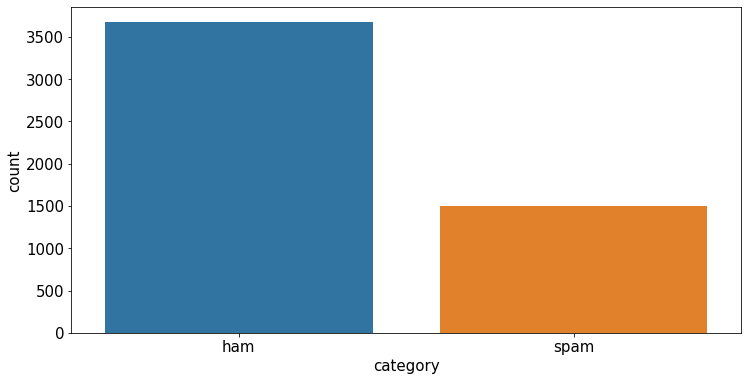

In [13]:
# Bar Plot for spam and ham distribution
fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(x = category_count.index, y = category_count['count'], ax = ax)
ax.set_ylabel('count', fontsize = 15)
ax.set_xlabel('category',fontsize = 15)
ax.tick_params(labelsize=15)

### Observation: 
it is clear from the plot, this seems to be "imbalaned data" where count of spam text is less than
ham text. There could be few reasons. 
Structure of "SPAM" Emails:
* Bad Grammer
* Bad links
* Time based such as "Hurry" "Act now" and many more

Most of the above constrains already we have removed in PreProcessing Part. Hence the length of the
Spam text become short.

## EDA Part 2: Word Cloud
Word cloud is the most common way to analyze the most frequent word in the dataset.

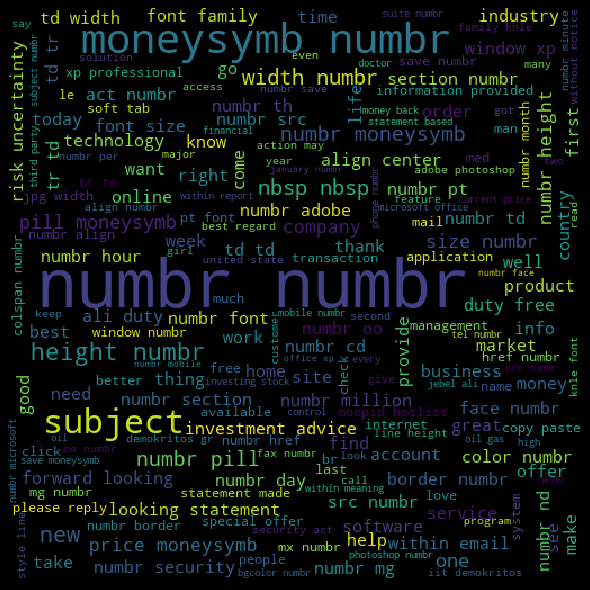

In [14]:
#word cloud for spam
spam_words = ' '.join(df[df['Category']=='spam']['lemmetize'])
spam_wc = WordCloud(width=512,height=512).generate(spam_words)
plt.figure(figsize = (10,8),facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

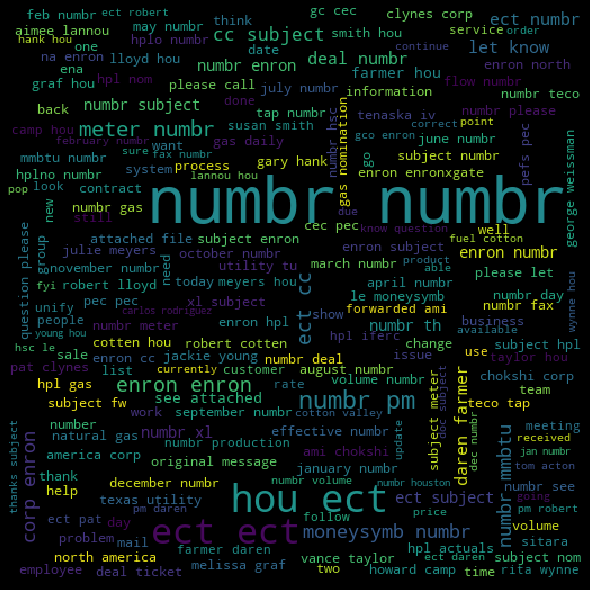

In [15]:
ham_words = ' '.join(df[df['Category']=='ham']['lemmetize'])
ham_wc = WordCloud(width=512,height=512).generate(ham_words)
plt.figure(figsize = (10,8),facecolor = 'k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Observation
As we can see in "spam" words Such as "Numbr(Number)","moneysmb($ converted into moneysmbl)","today(time based)"
frequently occured.

In the "Ham" words such as "Numbr","attached file","meeting" frequently occurs which shows the
autheticity of the Emails.

## EDA Part 3: Box Plot

In [16]:
#Length of Email length
#Length of Email length
df['lemmetize_len'] = df['lemmetize'].apply(len)

In [17]:
df.groupby('Category').describe()

lemmetize_len                                                        \
                 count        mean          std   min     25%    50%     75%   
Category                                                                       
ham             3672.0  671.278322   933.945609  15.0  170.00  370.0  833.50   
spam            1500.0  931.212000  1466.965817   7.0  197.75  408.0  922.25   

                   
              max  
Category           
ham       21254.0  
spam      21398.0

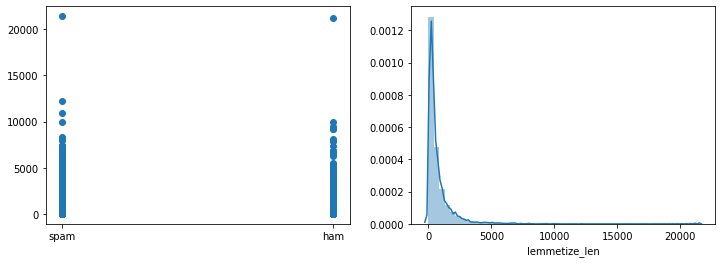

In [18]:
import matplotlib.pyplot as ply
plt, axes = ply.subplots(nrows = 1, ncols = 2,figsize = (12,4))
axes[0].scatter(x='Category', y='lemmetize_len', data=df)
sns.distplot(df['lemmetize_len'], ax=axes[1])

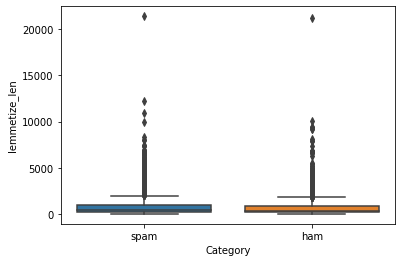

In [19]:
#Box plot
sns.boxplot(x='Category', y='lemmetize_len', data=df)

### Observation:
* As per the Box plot, we have Q1 = 170 , Q2= 370 and Q3= 833 for ham and for spam these values are
197,408 and 922 which mean IQR1 = 633 IQR2 = 725.

* The Length for Email in Spam in Positively Skwed as compare to Ham.
* As per the Box plot, I could observe the "Outlier" in both Spam and "Ham" data. The ratio of outlier in both of the data seems to be the same.

* We can still remove the outlier by performing the below step
#df[df['Email_len'] >= 20000].index
#df.drop(df[df['Email_len'] >= 20000].index, axis = 0, inplace=True)

Sice the outliers in the data can be seen after the range of 20000 Hence.I did not perform the outlier removal operation in my EDA.

### EDA Part-4 - Most Common 20 Words

##### Steps to follow:
* Create a subset of a data(data frame) such as spam_df and ham_df and tokenize the column. why tokenize? The reason since we have to find the most common "words" which is again called as a Token(single value in a list).

In [20]:
#Subdata frame from X_train
spam_df = df[df['Category'] == 'spam'] #create sub-dataframe of spam text
ham_df = df[df['Category'] == 'ham'] #sub-dataframe of ham text

In [21]:
#Dropping the columns since we need to tokenize only the final column
spam_df.drop(['Emails','clean','stop words removal','lemmetize_len'], axis=1,inplace=True)

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
spam_df['tokenized_sents_spam'] = spam_df.apply(lambda row: nltk.word_tokenize(row['lemmetize']), axis=1)
spam_df.head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Category,lemmetize,tokenized_sents_spam
0,spam,subject dobmeos hgh energy level gone stukm in...,"[subject, dobmeos, hgh, energy, level, gone, s..."
1,spam,subject prescription ready oxwq f e low cost p...,"[subject, prescription, ready, oxwq, f, e, low..."
2,spam,subject get new car numbr people nowthe weathe...,"[subject, get, new, car, numbr, people, nowthe..."
3,spam,subject await response dear partner team gover...,"[subject, await, response, dear, partner, team..."
4,spam,subject coca cola mbna america nascar partner ...,"[subject, coca, cola, mbna, america, nascar, p..."


In [23]:
#Dropping the columns since we need to tokenize only the final column
ham_df.drop(['Emails','clean','stop words removal','lemmetize_len'], axis=1,inplace=True)

In [24]:
#Tokenized for ham df as well
ham_df['tokenized_sents_ham'] = ham_df.apply(lambda row: nltk.word_tokenize(row['lemmetize']), axis=1)
ham_df.head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Category,lemmetize,tokenized_sents_ham
1500,ham,subject christmas tree farm picture,"[subject, christmas, tree, farm, picture]"
1501,ham,subject vastar resource inc gary production hi...,"[subject, vastar, resource, inc, gary, product..."
1502,ham,subject calpine daily gas nomination calpine d...,"[subject, calpine, daily, gas, nomination, cal..."
1503,ham,subject issue fyi see note already done stella...,"[subject, issue, fyi, see, note, already, done..."
1504,ham,subject meter numbr nov allocation fyi forward...,"[subject, meter, numbr, nov, allocation, fyi, ..."


In [25]:
#most common words in spam
#Empty list to store the words
spam_words = []
#Iterate through every word as token
for token in spam_df['tokenized_sents_spam']:
    spam_words = spam_words + token #combine text in different columns in one list
ham_words = []
for token in ham_df['tokenized_sents_ham'] :
    ham_words += token

In [26]:
#Counter(package from collection library) count the words 
spam_count = Counter(spam_words).most_common(20)
ham_count = Counter(ham_words).most_common(20)

In [27]:
#Creating seperate columns out of data frame to store words and their frequencies
spam_count_df = pd.DataFrame(spam_count, columns = ['word', 'count'])
ham_count_df = pd.DataFrame(ham_count, columns = ['word', 'count'])

Text(0.5, 1.0, 'Spam top 20 words')

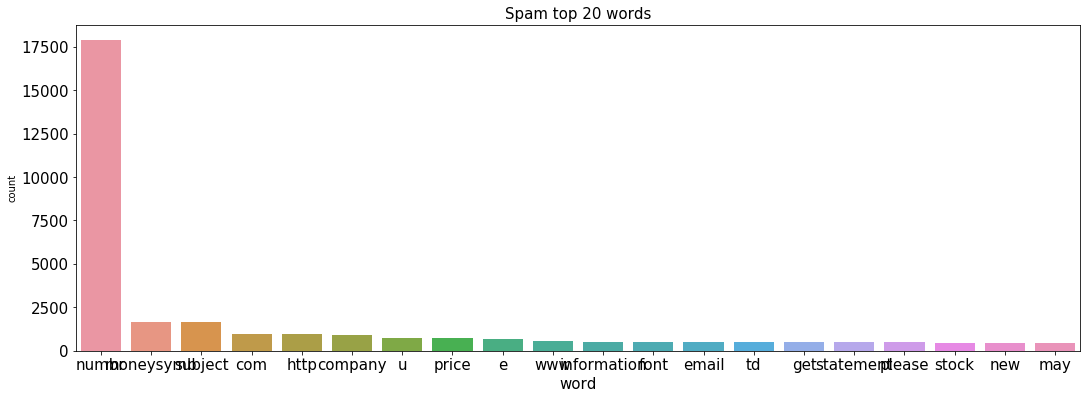

In [30]:
#Bar plot for most common 20 words
fig, (ax) = plt.subplots(1,figsize = (18, 6))
sns.barplot(x = spam_count_df['word'], y = spam_count_df['count'], ax = ax)
ax.set_ylabel('count', fontsize = 10)
ax.set_xlabel('word',fontsize = 15)
ax.tick_params(labelsize=15)
ax.set_title('Spam top 20 words', fontsize = 15)             

Text(0.5, 1.0, 'ham top 20 words')

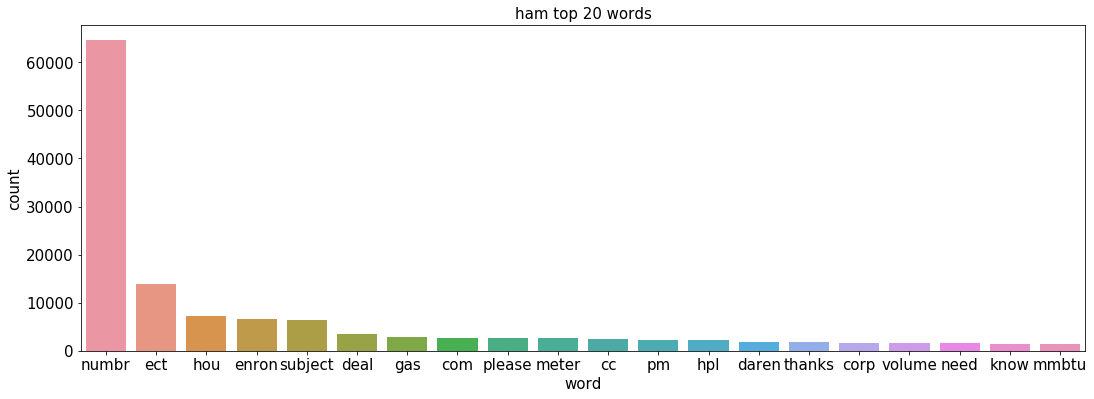

In [28]:
#Most common words in Ham Bar plot
fig, (ax1) = plt.subplots(1,figsize = (18, 6))
sns.barplot(x = ham_count_df['word'], y = ham_count_df['count'], ax = ax1)
ax1.set_ylabel('count', fontsize = 15)
ax1.set_xlabel('word',fontsize = 15)
ax1.tick_params(labelsize=15)
ax1.set_title('ham top 20 words', fontsize = 15)

### Observation
* We Can see "numbr" is the most frequent in both Spam and non spam messages.
* "http" occurs more in Spam email may be in the form of "Bad links".
* "Price" occurs more in Spam emails may be in the form of "Tempting offers"
* "get statement" again more in Spam emails in the form of "Fraud transaction".

## Feature Extraction - Count Vectorization
Feature Extraction also knows as Vectorization which means "Process of converting text into
form of integer to create feature vectors", also known as "Bag of words".

Steps to follow:
* Count the word frequency of each word
* min_df = Represent the cut-off value for the vocabulary, it words appears one time it should         dislay the word frequency
* max_df = We can specify the if we want to consider most frequent values in my data? Such as 
  giving 0.50 means if the terms appers more than  50% should it will ignore these terms.
  Here,considered all the values defining max_df = 1
* max_features = None which means vectorizer will learn all the features.
* ngrams_range = range for consecutive words to display. Here i am displaying 2 consecutive
  words.
    

    
 
 Note : We have another method to perform the similar operation just like count vector called "Tf-           idf". tf-idf which will provide the Inverse document frequency.

In [31]:
count_vect = CountVectorizer()
# Transforms the data into a bag of words
vector_counts = count_vect.fit_transform(df.lemmetize)
vector_counts
#print("Every feature:\n{}".format(count_vect.get_feature_names()))
#print("\nEvery 3rd feature:\n{}".format(count_vect.get_feature_names()[::3]))

<5172x43181 sparse matrix of type '<class 'numpy.int64'>'
	with 319210 stored elements in Compressed Sparse Row format>

### Vocabulary and vocabulary ID

In [ ]:
#print("Vocabulary size: {}".format(len(count_vect.vocabulary_)))
#print("Vocabulary content:\n {}".format(count_vect.vocabulary_))

### N-grams (sets of consecutive words)

In [ ]:
#N-grams
#print(count_vect.get_feature_names())

In [32]:
total_counts_df = pd.DataFrame(vector_counts
.toarray())
total_counts_df

,0,1,2,3,4,5,6,7,8,9,...,43171,43172,43173,43174,43175,43176,43177,43178,43179,43180
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5168,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5170,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Train and Test Split

In [33]:
#Split the Entire data in Train and Test data.
X_train, X_test, y_train, y_test = train_test_split(total_counts_df,df.Category,test_size=0.3,random_state=42)


In [34]:
X_train.shape

(3620, 43181)

## Buliding Models

### 1.1 Cross Validation: 
Cross Validation is the process where we valiadate our model first on Traning data using multiple folds and find the accuracy of the model. In the process of CV we validate our traning data which "ACT AS" test data.

#### Why it is important to perform cross validation? Few Reasons why?
* For Example, if we split the data into Test and Train data with random_state = 5 and build a model   with value X_train ==   Features and y_train == Predictor and apply on the test data suppose we get   accuracy = 90% again if we   change value of random_state while the acuuracy will get affacted.        Thats the reason most of the time test data is classified as "High Variance estimate". To solve      high variance issue we can perfrom cross validation on the train data and get the Accuracy which      is known as "Out of sample error".

#### Comparing Cross validation to test/train split
 Cross Validation : More Accurate results of out of sample accuracy
 test/train split : Run Faster than Cross Validation since CV Repets the process n times
 
 #### Recommnded Cross Validation for Classification
 * For Classification Problem such as "Ham" and "Spam" stratified sampling is recommnded thankfully 
   cross_val_score from scikits learn automatically do this job for us.

In [122]:
#clf = MultinomialNB()
#clf.fit(X_train,y_train)
#preds = clf.predict(X_test)
#acc_Nb=accuracy_score(preds,y_test)
#acc.append(acc_Nb)
#print("Accuracy Score",acc)
#conf_mat=confusion_matrix(y_test,preds)
#print("Confusion Matrix  : \n",conf_mat)
#pd.DataFrame(data = conf_mat, columns = ['Predicted HAM', 'Predicted SPAM'],
            #index = ['Actual HAM', 'Actual SPAM'])
#confusion_matrix_mat

In [35]:
#Store all the model accuracy in a list
cross_validation_accuracy=[]
model_names=['MultinomialNB','RandomForest','SVM','K Nearest Neighbour','BernoulliNB']

#### Multinomial Naive Bayes Classification
Naive Bayes : Naive Bayes is a classification algorithm for Binary or multiclass classification 
problem. It calculates the probability of the of the data with respect to the given class.
In my part class is "Ham" and "Spam".P(class|data) = (P(data|class) * P(class)) / P(data)
Where P(class|data) is the probability of class given the provided data.

Multinomial  Naive Bayes: MNB usully works best with the text classification.Where Features will be
generated with the multinomial distribution and then multinomial distribution describe the probabilty
of count observe of the given class.

##### Note: In order to count the document frequency we will perform the feature enginnering here
with the help of Tf-idf and count vector.it will provide the word frequncy.

In the below lines of code I am using the cross validation of the training data and finding
the accuracy

Final Accuracy :97.23

In [36]:
# Naive Bayes Classifier
clf = MultinomialNB()
cv_scores = cross_val_score(clf, X_train, y_train, cv=10)
#use average accuracy as an estimate of out of sample accuracy
print("Mean 10-Fold Accuracy Score: {}".format(np.mean(cv_scores)))
cross_validation_accuracy.append(np.mean(cv_scores))

Mean 10-Fold Accuracy Score: 0.972371040284824


### Random Forest Classification
Random forest, like its name implies, consist of multiple decision trees, with class prediction.
Class with the higher number of votes will become the our model's Prediction. Votes of a class
depends on various factors based on the factors we can perform bagging and boosting on our data.
if we combine the terms together it become "Ensemble" technique.

Here in the below lines of code, I am performing cross validation on training set to get the 
accuracy with the 10 folds.

Final Accuracy: 94.89


In [37]:
#Random Forest
classifier = RandomForestClassifier()#(n_estimators = 10, criterion = 'entropy', random_state = 100)
#classifier.fit(X_train, y_train)
cv_scores = cross_val_score(classifier, X_train, y_train, cv=10)
print("Mean 10-Fold Accuracy Score: {}".format(np.mean(cv_scores)))
cross_validation_accuracy.append(np.mean(cv_scores))

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change 

Mean 10-Fold Accuracy Score: 0.950010527521585


### Support Vector Machine Classification
SVM: SVM used for high dimensional data points so that the data can easlity be categorized 
in a hyperplane.it mainly uses "kernal" trick to tranform your data and based on the transformation
it founds a boundry between the outputs

Advantages:
* Data points of different categires can be seperate as wide as possible
* It uses subset of a training point the decision function that makes it memory effiecint.

Disadvatages:
* SVM will not directly provide the probabality estimate so the probabilty can be calculated by
cross validation.

Final Accuracy :95.80


In [38]:
#Cross Validation SVM
clf = svm.LinearSVC(loss='hinge')
#clf.fit(X_train,y_train)
cv_scores = cross_val_score(clf, X_train, y_train, cv=10)
print("Mean 10-Fold Accuracy Score: {}".format(np.mean(cv_scores)))
cross_validation_accuracy.append(np.mean(cv_scores))

D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\s

Mean 10-Fold Accuracy Score: 0.958017028108061


### K Nearest Neighbour
KNN is an apparoach to classify new data points based on the some similarity measures
(distance function). Whichever class get the highest votes will classify the new data with the same
votes. K == the number of nearest neighbour.

#### How does k affct knn?
Larger k value provies more smoothing. if we change the value of k it will affct the accuracy 
of our model.

#### How to choose the k-value?
As we know the value of k is based on our traning section. Hence the best way to choose k value is
k value = sqrt(N)/2 where N = Total Traning samples.

Final Accuracy: 82.48

In [39]:
#KNN Cross Validation
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
cv_scores = cross_val_score(knn, X_train, y_train, cv=10)
print("Mean 10-Fold Accuracy Score: {}".format(np.mean(cv_scores)))
cross_validation_accuracy.append(np.mean(cv_scores))

Mean 10-Fold Accuracy Score: 0.8248506805766553


### Bernoulli Naive Bayes
Bernoulli NB: It should be used for features with binary or boolean values like True/False or 0/1.
The difference between the Multinomial and binary is Multinomail takes the discrate data whereas
bernolli takes 0's and 1's.

In [40]:
from sklearn.naive_bayes import BernoulliNB

In [41]:
bnb = BernoulliNB(binarize=0.0)
cv_scores = cross_val_score(bnb, X_train, y_train, cv=10)
print("Mean 10-Fold Accuracy Score: {}".format(np.mean(cv_scores)))
cross_validation_accuracy.append(np.mean(cv_scores))

Mean 10-Fold Accuracy Score: 0.8375662887088262


In [42]:
#dictionary to store the key and value
dic={'Modelling Algorithms':model_names,'Cross Vaidation Accuracy':cross_validation_accuracy}
met_df=pd.DataFrame(dic)
met_df.sort_values(by='Cross Vaidation Accuracy',ascending=False)

,Modelling Algorithms,Cross Vaidation Accuracy
0,MultinomialNB,0.972371
2,SVM,0.958017
1,RandomForest,0.950011
4,BernoulliNB,0.837566
3,K Nearest Neighbour,0.824851


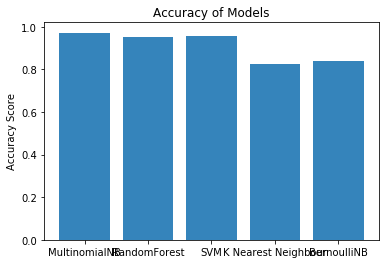

In [43]:
#Accuracy plot for models
y_pos = np.arange(len(model_names))
y_val = [ x for x in cross_validation_accuracy ]
plt.bar(y_pos,y_val, align='center', alpha=0.9)
plt.xticks(y_pos, model_names)
plt.ylabel('Accuracy Score')
plt.title('Accuracy of Models')
plt.show()

#### Observation
As per the accuracy plot it is clear that, Multinomail, SVM and Random forest all 3 almost have 
the similar accuarcy where Multimial has the highest.

## Model Selection -- Hyper Parameter Tunning
As per the above "cross validation accuracy score" I have selected 3 models name "MultinomialNB",
"SVM" and "RandomForest". In the process of Model Selection, prediction will apply on Training model for all three models.



#Plot the confusion Matrix
plt.clf()
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Spam','Ham']
plt.title('Email')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(conf_mat[i][j]))
plt.show()

### Hyper parameter tuning for Random Forest
Hyper parameter tuning is a process to adjust the parameter of a model in order to improve the accuracy of the model.

Hyper paramters of Random forest:
n_estimators: Specifies the number of tress to be constructed. In the below tuning code supplied values are n_estimators': [10, 20, 40]} and resulted best is n_estimators=100.which means 100 different tress can be constructed in the random forest.

max_depth: max_depth specifies the extent of the expand level of a tree node.
            Supplied Parameter : max_depth': [10, 30],
            Resulted Parameter : max_depth=None,
min_sample_splits : which means minimum number of samples required to split an internal node.Default
value is 2.

            Supplied Parameter: 'min_samples_split': [2, 5, 7],
            Resulted Parameter: min_samples_split=2,
min_samples_leaf:Minimum number samples to be needed for a leaf node.

            Supplied Parameter:'min_samples_leaf': [1, 2],
            Resulted Parameter: min_samples_leaf=1

In [68]:
#Hyper parameter tuning for Random Forest
#clf = RandomForestClassifier()
#clf.fit(X_train,y_train)

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
Fit the tuning parameters
#param_grid={'bootstrap': [True, False],
                         #'criterion': ['gini', 'entropy'],
                         #'max_depth': [10, 30],
                         #'max_features': ['auto', 'sqrt'],
                         #'min_samples_leaf': [1, 2],
                         #'min_samples_split': [2, 5, 7],
                         #'n_estimators': [10, 20, 40]},
         #pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             #scoring=None, verbose=2)

In [ ]:
#grid_search_RF = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param,cv = 5, n_jobs = -1, verbose = 2)

In [84]:
#Validation Curve
from sklearn.model_selection import validation_curve
param_range = np.arange(1, 5, 2)
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = param_range, cv = 3)

### Result of Hyper Paramter tuning on Random Forest

In [45]:
clf = RandomForestClassifier(n_estimators=100,random_state=None,min_samples_split=2,min_weight_fraction_leaf=0.0 )
clf.fit(X_train,y_train)
preds = clf.predict(X_train)
acc_nb=accuracy_score(preds,y_train)
acc_nb

1.0

### Below are the Best paramter for Random Forest after Tunning

In [ ]:
# GridSearchCV(cv=3, error_score=nan,
#         estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
#         class_weight=None,
#         criterion='gini', max_depth=None,
#         max_features='auto',
#          max_leaf_nodes=None,
#         max_samples=None,
#         min_impurity_decrease=0.0,
#         min_impurity_split=None,
#         min_samples_leaf=1,
#         min_samples_split=2,
#         min_weight_fraction_leaf=0.0,
#         n_estimators=100, n_jobs=None,...
#         random_state=None, verbose=0,
#         warm_start=False),
        
#      iid='deprecated', n_jobs=-1,

### Hyper Parameter Tuning for SVM
Types of Kernal 
* Linear Kernal : This kernal can be used as a normal dot product between any given two observations.
* Polynomial Kernal : Distinguish between curved and non linear curve
* Radial Basis function : It can map the Space in infinte dimensions, thats why it is the most         commonly used kernal. I have got the kernel= 'rbf' as a best hyper parameter kernal after tuning.

In [69]:
#Hyper parameter tuning for SVM
clf = SVC()
clf.fit(X_train,y_train)

D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
#Fit the tuning parameters
param = {'C': [0.1, 1, 10, 100, 1000],  
         'gamma': ['scale', 'auto'], 
         'kernel': ['rbf','linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘radial']}  
  
grid_search_SVM = GridSearchCV(estimator = SVC(),param_grid=param,cv = 5, n_jobs = -1, verbose = 2)
grid_search_SVM.fit(X_train,y_train)

### Best Tuned Parameter of SVM

In [ ]:
# (cv=5, error_score=nan,
#              estimator=SVC(C=1.0, break_ties=False, cache_size=200,
#                            class_weight=None, coef0=0.0,
#                            decision_function_shape='ovr', degree=3,
#                            gamma='scale', kernel='rbf', max_iter=-1,
#                            probability=False, random_state=None, shrinking=True,
#                            tol=0.001, verbose=False),
#              iid='deprecated', n_jobs=-1,)


In [21]:
#Accuracy Check after tuninng
from sklearn.svm import SVC
clf = SVC(C=1.0,cache_size=200,
                            class_weight=None, coef0=0.0,
                            decision_function_shape='ovr', degree=3,
                            gamma='scale', kernel='rbf', max_iter=-1,
                            probability=False, random_state=None, shrinking=True,
                            tol=0.001, verbose=False)
clf.fit(X_train,y_train)
preds = clf.predict(X_train)
acc_nb=accuracy_score(preds,y_train)
acc_nb

0.9552486187845304

#### Observation:
After SVM Model Hyper-paramter tuning it is clear that the Accuracy is not improving and remains
same at ~96%. Hence for further Model Evaluation i will not consider SVM as my best model.

##  Model Evaluation
Model Evaluation is the Process to which helps us to find the best model out of the compared models
and also let us know how choosen model will work on the future unseen data.In my data

* Firstly, I performed cross validation on 5 models 'MultinomialNB','RandomForest','SVM',
 'K Nearest Neighbour','BernoulliNB' and have got the highest frequency for Multinomail Naive bayes
  model followed by SVM and Random Forest.
* Clearly, After tunning RF i can get 100% Accuracy I will select this model for further Evaluation

#### Below are model evaluation metrics
* Classification Accuracy
* Confusion matrix
* F-Measure

#### Classification Accuracy for RF
Classification Accuracy is the measure evaluation metrics which will give ratio of correct
prediction.

In [53]:
#fit model
clf = RandomForestClassifier(n_estimators=100,random_state=None,min_samples_split=2,min_weight_fraction_leaf=0.0 )
clf.fit(X_train, y_train)
#accuracy on test set
pred = clf.predict(X_test)
acc_Nb=accuracy_score(pred,y_test)
conf_mat=confusion_matrix(y_test,pred)
print("Confusion Matrix  : \n",conf_mat)
print(acc_Nb)

Confusion Matrix  : 
 [[1058   26]
 [  14  454]]
0.9742268041237113


#### Observation: 
The classification accuracy is 97.55% on the validation set/test set.Few things to notice here
* Accuracy on the test data eventully increased as compare to cross validation(94.48%).
* Another Reason for higher accuracy are the "Tuned hyper parameters".

#### Confusion matrix for RF
A confusion matrix provides a more detailed breakdown of correct and incorrect classifications 
for each class.

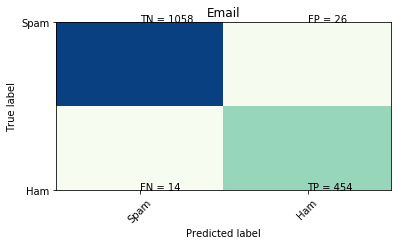

In [54]:
#Plot the confusion Matrix
plt.clf()
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.GnBu)
classNames = ['Spam','Ham']
plt.title('Email')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(conf_mat[i][j]))
plt.show()

#### Confusion Matrix Observation

* As per the above figure, CF have lables as 
  
True Negative(TN): Predicted negative actully negative (1062)
False Positive(FP): Predicted Positive actully negative(22)
False Negative(FN): Predicted Negative actully positive(16)
True Positive(TP): Predicted Positive actully positive(452)
    
#### How Many Emails are correctly classified by the RF Model?
1062 == Spam 452 == Ham thats how we got the model accuracy 97.55%
out of 5172 we got 1514 correct.

#### How many Emails are misclassified
FP+FN = 22+16 == 38

### F-Measure
F-measure is the measure of test accuracy considers both term "Precision" and "Recall" where
Precision means number of correct positive results divided by the total predicted positive observations.
and Recall means n the other hand, is the number of correct positive results divided by the number of all relevant samples 
(total actual positives).

In [55]:
from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, accuracy_score,f1_score,classification_report

In [56]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         ham       0.99      0.98      0.98      1084
        spam       0.95      0.97      0.96       468

    accuracy                           0.97      1552
   macro avg       0.97      0.97      0.97      1552
weighted avg       0.97      0.97      0.97      1552



### Observation
* Out of 452+16 = 468 we correctly identified 452 Emails which are correctly Classified, is known
   as "Recall"

* Out of 452+22 = 474 which we predicted to be Positive 522 actully were positive, is known as
   "Precision"

### Challanges
* Due to low GPU in my system most if the time hyper parameter process got stuck and took lot
  of time for complete Run. Hence I got to run on another machine, just included the Result not Run.

### TakeAway

1)I found the data is Highly Imbalanced.I think that could be one reason to get the very high accuracy which is usully uncommon to see.

2)Since the data is highly imbalanced, i have not considered ROC.

### References

Below are some references i have used for my code

1)http://localhost:8888/notebooks/Downloads/SMSspam.ipynb

2)https://www.kaggle.com/larui529/spam-vs-ham-text-filter

3)https://www.kaggle.com/nagamanir/sms-spam-collection-eda